#### Exercise 5

Forecast and represent the solar energy production of 2017, by using years from 2012 to 2016 as training data.

You should use at least 2 different models and compare results.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

from utils.helpers import regression_results, rmse, parser

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 15.0)
sns.set()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
url_data = "https://raw.githubusercontent.com/fbagattini/Lezioni/master/data/OPSD_Germany_all.csv"

In [ ]:
df = pd.read_csv(url_data,
                 parse_dates=True,
                 index_col='Date')

In [ ]:
df.head()

,Consumption,Wind,Solar
Date,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN
2006-01-04,1457.217,NaN,NaN
2006-01-05,1477.131,NaN,NaN


In [ ]:
# creating new dataframe from Solar column
data_solar = df[['Solar']]

# inserting new column with yesterday's Solar values
data_solar.loc[:,'Yesterday'] = data_solar.loc[:,'Solar'].shift()

# inserting another column with difference between yesterday and day before yesterday's So values.
data_solar.loc[:,'Yesterday_Diff'] = data_solar.loc[:,'Yesterday'].diff()

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
data_solar.describe()

,Solar,Yesterday,Yesterday_Diff
count,2188.000000,2187.000000,2184.000000
mean,89.258695,89.290372,-0.024712
std,58.550099,58.544733,28.408319
min,1.968000,1.968000,-111.905000
25%,35.179250,35.198500,-15.236000
50%,86.407000,86.424000,0.571000
75%,135.071500,135.092000,15.872500
max,241.580000,241.580000,112.089000


In [ ]:
# set frequency
data_solar.index = data_solar.asfreq('D').index

In [ ]:
# dropping NaNs
data_solar = data_solar.dropna()

In [ ]:
data_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2182 entries, 2012-01-03 to 2017-12-31
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Solar           2182 non-null   float64
 1   Yesterday       2182 non-null   float64
 2   Yesterday_Diff  2182 non-null   float64
dtypes: float64(3)
memory usage: 68.2 KB


In [ ]:
data_solar.head()

,Solar,Yesterday,Yesterday_Diff
Date,,,
2012-01-03,24.679,6.574,-0.013
2012-01-04,14.681,24.679,18.105
2012-01-05,5.071,14.681,-9.998
2012-01-06,13.160,5.071,-9.610
2012-01-07,4.115,13.160,8.089


In [ ]:
X_train = data_solar.loc[:'2016'].drop(['Solar'], axis = 1).values
y_train = data_solar.loc[:'2016', 'Solar'].values

X_test = data_solar.loc['2017'].drop(['Solar'], axis = 1).values
y_test = data_solar.loc['2017', 'Solar'].values

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10)))

LR: 0.607620 (0.200598)
KNN: 0.553358 (0.233815)
RF: 0.523535 (0.238751)


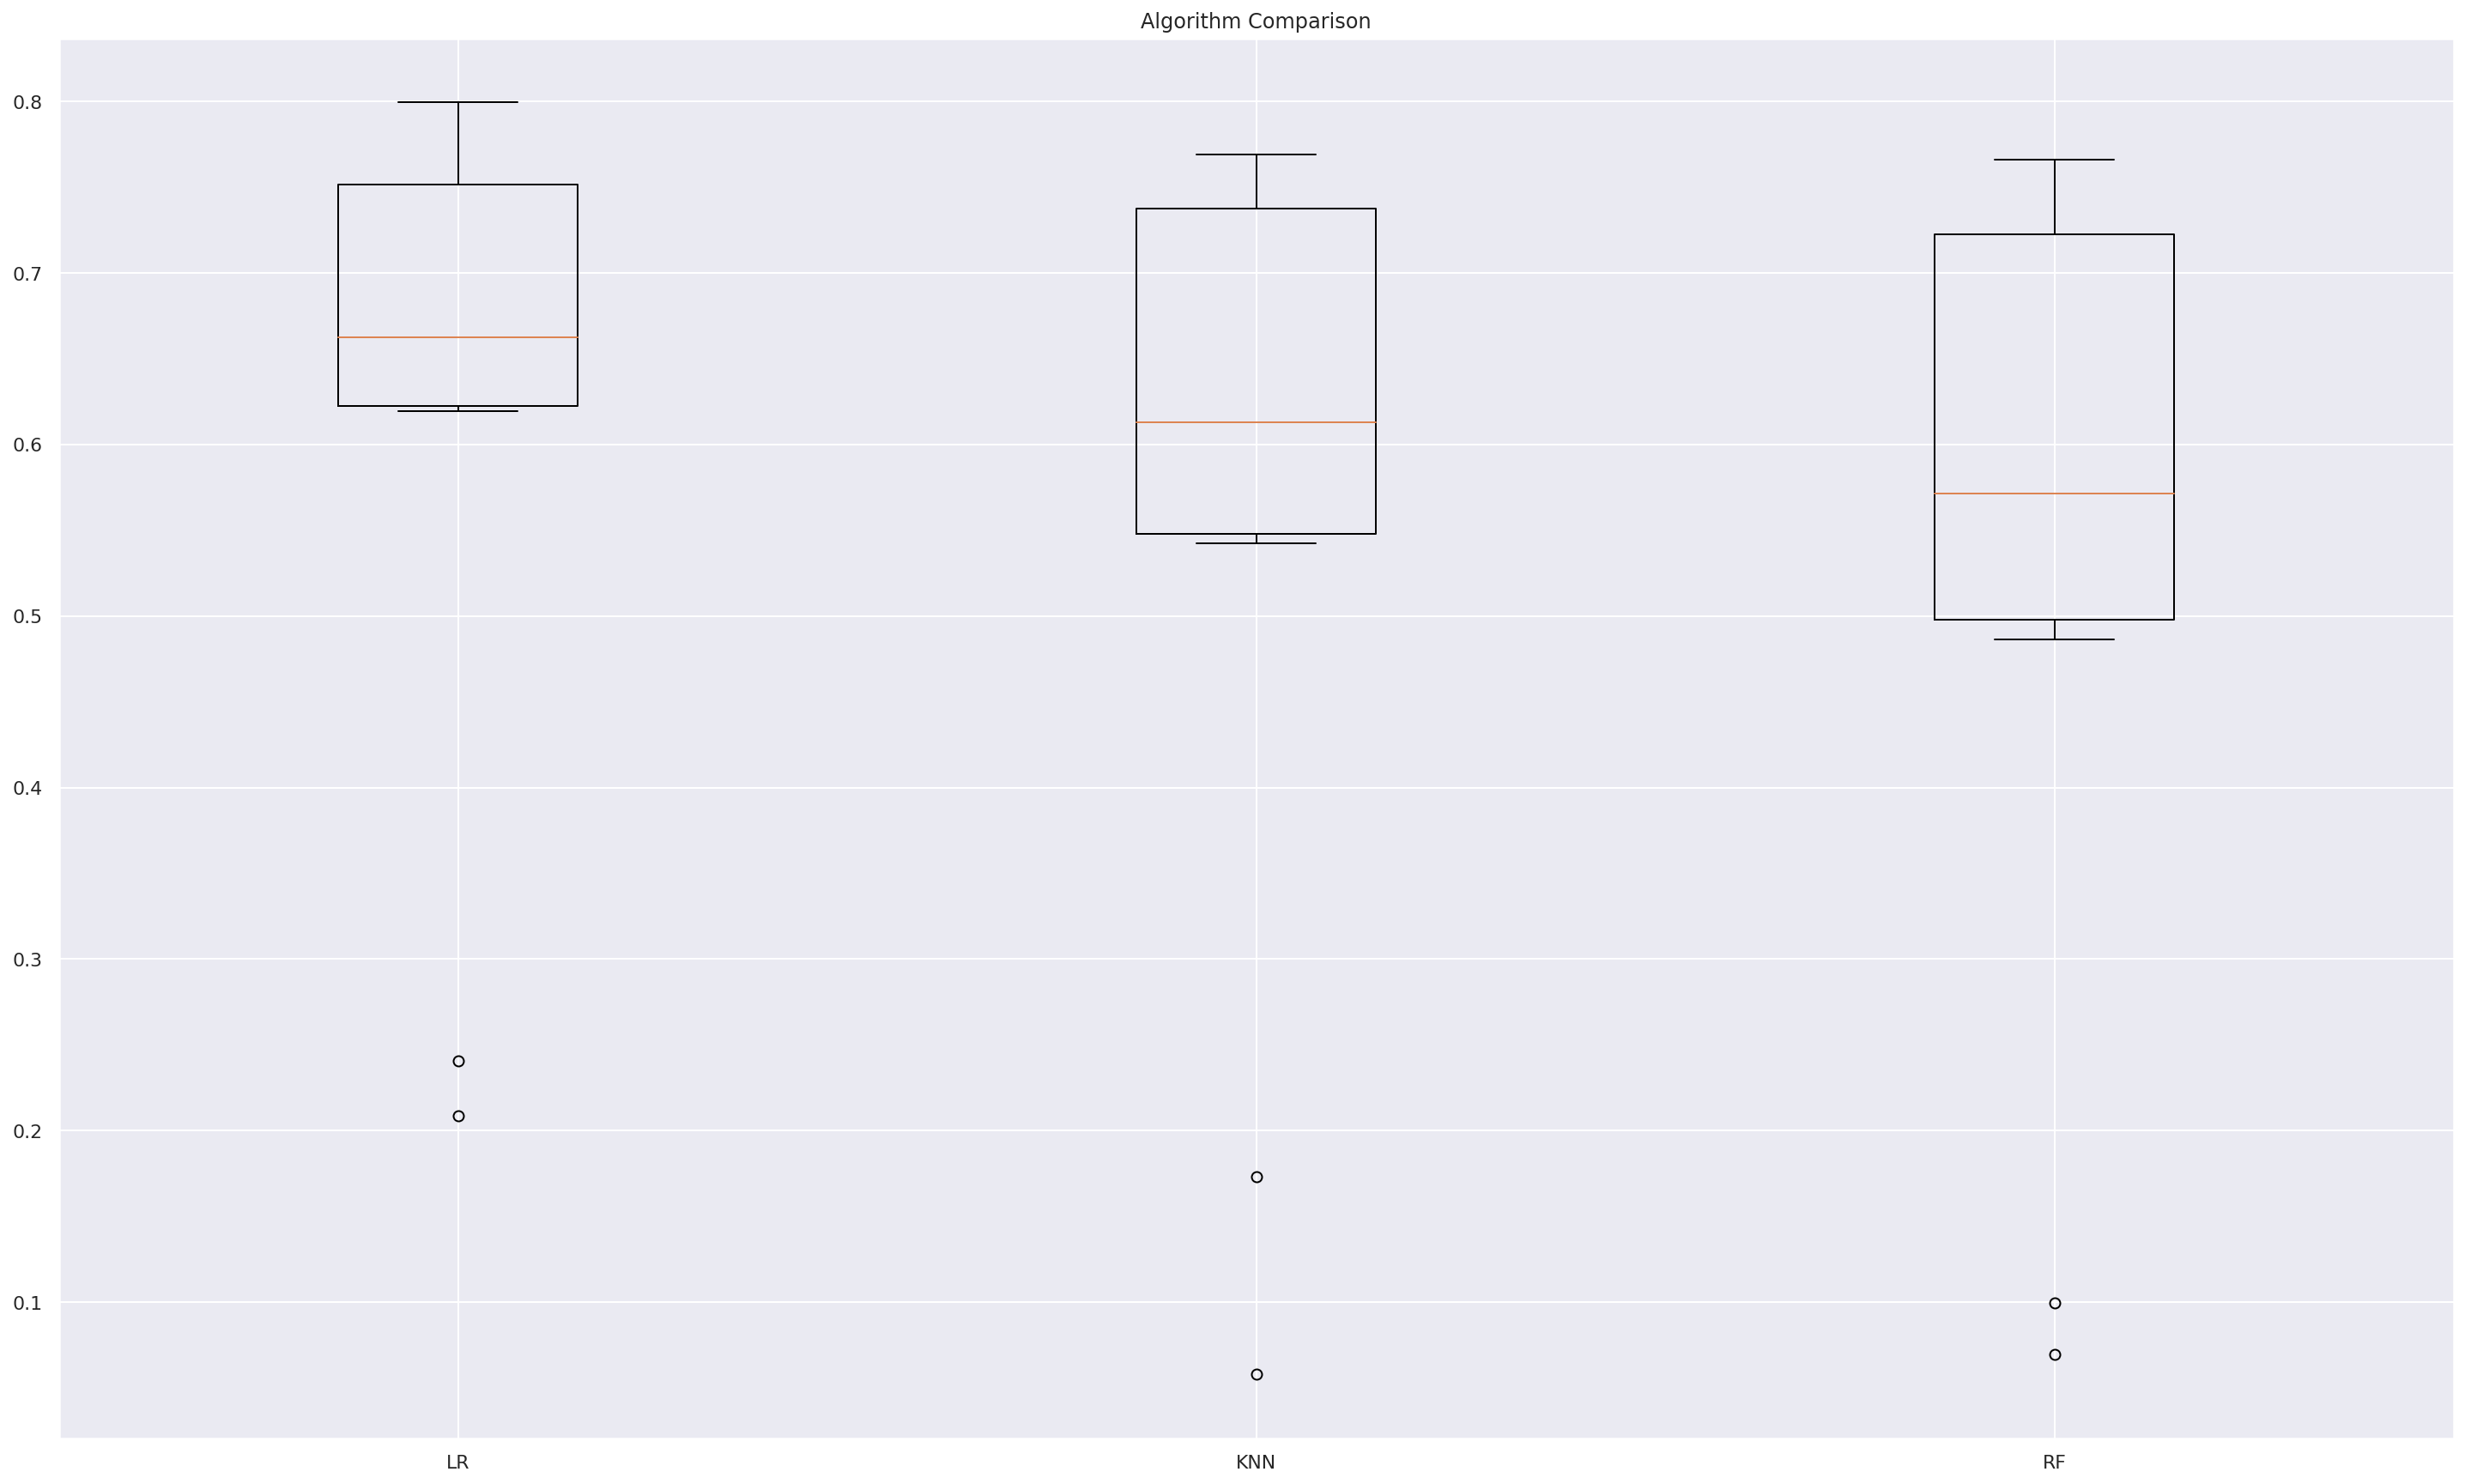

In [ ]:
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
#Gridsearch for KNN Hyperparameters

rmse_score = make_scorer(rmse, greater_is_better = False)
model = KNeighborsRegressor()
param_search = { 
    'weights': ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10, 20, 30, 40, 50],
    'p' : [1, 2]

}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
#evaluate on test data

y_pred = best_model.predict(X_test)
regression_results(y_test, y_pred)

explained_variance:  0.7775
mean_squared_log_error:  0.166
r2:  0.7771
MAE:  23.4161
MSE:  932.2764
RMSE:  30.5332


In [ ]:
#Gridsearch for Random Forest Hyperparameters

rmse_score = make_scorer(rmse, greater_is_better = False)
modelRF = RandomForestRegressor()
param_searchRF = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearchRF = GridSearchCV(estimator=modelRF, cv=tscv, param_grid=param_searchRF, scoring = rmse_score)
gsearchRF.fit(X_train, y_train)
best_scoreRF = gsearchRF.best_score_
best_modelRF = gsearchRF.best_estimator_

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

In [ ]:
#evaluate RF on test data

y_predRF = best_modelRF.predict(X_test)
regression_results(y_test, y_predRF)

explained_variance:  0.7945
mean_squared_log_error:  0.1469
r2:  0.7928
MAE:  21.9868
MSE:  866.2838
RMSE:  29.4327


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51473f4b-c066-448b-9585-b1955fea67d0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>